In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim

# Load the built-in flights dataset
flights = sns.load_dataset("flights")

# We will be predicting monthly passengers
data = flights["passengers"].values.astype(float)

# We use MinMaxScaler to normalize our dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))
data_normalized = torch.FloatTensor(data_normalized).view(-1)

In [2]:
# Prepare the dataset by creating sequences
train_window = 12

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(data_normalized, train_window)

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [4]:
epochs = 50  # Reduced epochs for faster training

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00303697
epoch:  10 loss: 0.07384013
epoch:  20 loss: 0.00383744
epoch:  30 loss: 0.00383953
epoch:  40 loss: 0.00181120
epoch:  49 loss: 0.0046841097


In [5]:
fut_pred = 12

test_inputs = data_normalized[-train_window:].tolist()
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))

MAE: 56.05
RMSE: 77.51


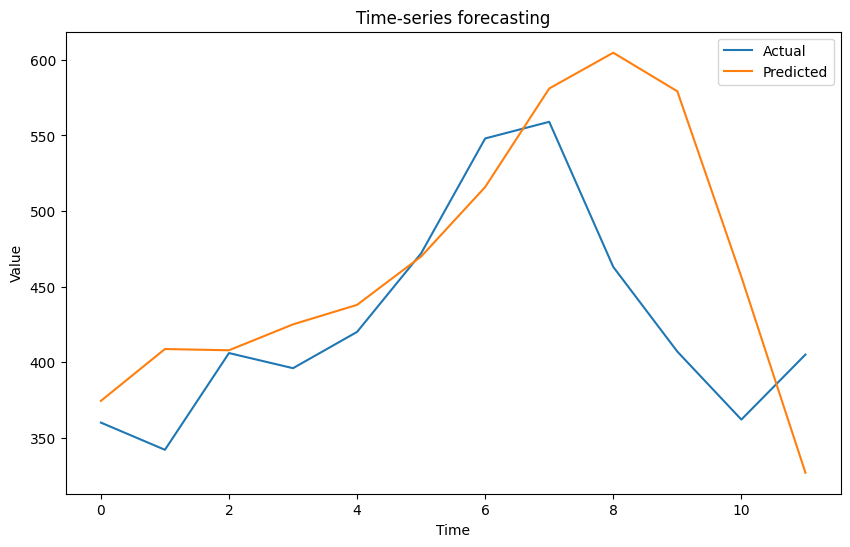

In [7]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use only the actual values corresponding to the prediction period
actual = scaler.inverse_transform(data_normalized[-(train_window + fut_pred):-train_window].numpy().reshape(-1, 1))
predicted = actual_predictions

mae = mean_absolute_error(actual, predicted)
rmse = math.sqrt(mean_squared_error(actual, predicted))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# Visualizing the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title('Time-series forecasting')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()